# Fastai Migration Notes (v2)

This notebook contains notes and experiments using fastai v2. Unfortunately, 
I cannot combine notes for both v1 and v2 in the same notebook because they
need to be run using different Python environments.

This notebook contains code adapted from `fastai-migration-notes-v1.ipynb` for fastai v2.

In [1]:
from collections import Counter
from pathlib import Path

import math
import seaborn as sns
import torchaudio
from tqdm.autonotebook import tqdm

/tmp/ipykernel_626326/2929937443.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


I'm going to create a subset of audio files to more quickly run through these notebooks. 

In [2]:
import random
import shutil

sample_folder = Path("data/sample/")

if not sample_folder.exists():

    raw_data_folder = Path("data/train/mldata/all/")
    all_files = list(raw_data_folder.rglob("*.wav"))

    random.seed(42)
    sample_files = random.sample(all_files, 100)

    sample_folder.mkdir(parents=True, exist_ok=True)
    for index, file in enumerate(sample_files):
        if index % 2 == 0:
            target_folder = sample_folder / "positive"
            target_folder.mkdir(exist_ok=True)
            shutil.copy(file, target_folder / file.name)
        else:
            target_folder = sample_folder / "negative"
            target_folder.mkdir(exist_ok=True)
            shutil.copy(file, target_folder / file.name)

## Data Check

In [3]:
data_folder = Path("data/sample/")
audio_files = list(data_folder.rglob("*.wav"))

len(audio_files)

100

In [4]:
def extract_metadata(items: list[Path]):
    """Extract audio metadata from each file."""
    metadata = dict()
    for item in tqdm(items):
        metadata[item] = torchaudio.info(item)
    
    sample_rates = Counter(x.sample_rate for x in metadata.values())
    print("Sample Rates:")
    for rate, count in sample_rates.items():
        print(f"- {rate} Hz: {count} files")
    
    return metadata

In [5]:
metadata = extract_metadata(audio_files)

  0%|          | 0/100 [00:00<?, ?it/s]

Sample Rates:
- 20000 Hz: 100 files


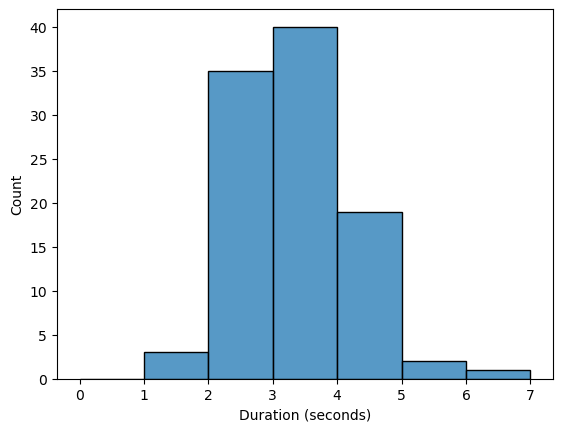

In [6]:
durations = [x.num_frames / x.sample_rate for x in metadata.values()]

plot = sns.histplot(
    durations, 
    binwidth=1,
    binrange=(0, math.ceil(max(durations)))
).set(xlabel="Duration (seconds)", ylabel="Count")

## Load Data

One of the key goals of this section is to ensure that the audio files converted into identical images (spectrograms) between v1 and v2.

In [7]:
audio_files[0]

PosixPath('data/sample/negative/1562340736_0004_5_7.188327420070585_call.wav')

In [8]:
import torchaudio.transforms as T

# Define the torchaudio transforms based on the AudioConfig parameters
transform_spec = T.MelSpectrogram(
    f_min=0.0,
    f_max=10000,
    hop_length=256,
    n_fft=2560,
    n_mels=256,
    pad=0,
    win_length=None,
)

# Convert to decibel scale
transform_db = T.AmplitudeToDB(top_db=100)

transform = lambda x: transform_db(transform_spec(x)).detach()

/anaconda/envs/orca-v2-env/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1281) may be set too low.
  warnings.warn(


In [9]:
path = audio_files[0]
signal, sample_rate = torchaudio.load(path)
tensor = transform(signal)

torch.Size([1, 256, 171])


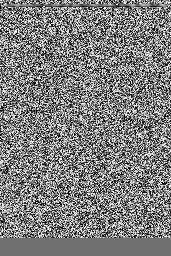

In [10]:
from torchvision.transforms import functional as F

print(tensor.shape)
image = F.to_pil_image(tensor)
image

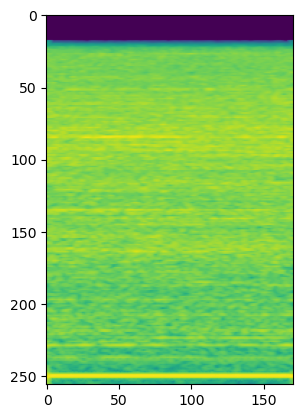

In [11]:
import matplotlib.pyplot as plt

def show_image(tensor):
    result = F.rotate(tensor, 180)
    result = F.hflip(result)
    result = result.cpu().permute(1,2,0).numpy()
    result = result[...,0] if result.shape[2]==1 else result
    plt.imshow(result)
    
show_image(tensor)

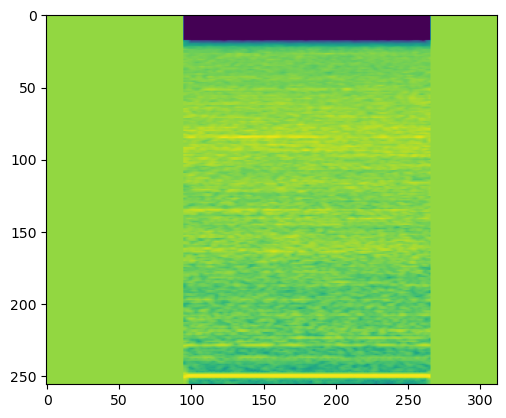

In [12]:
import torch

class PadOrCropTransform:
    def __init__(self, target_duration, hop):
        self.target_duration = target_duration
        self.hop = hop

    def __call__(self, data, sample_rate):
        output = data.clone()
        num_channels, height, width = output.shape
        target_width = int(sample_rate * self.target_duration / self.hop)

        if width < target_width:  # Pad
            missing_width = target_width - width
            left_pad_width = random.randint(0, missing_width)
            right_pad_width = target_width - width - left_pad_width
            pad_front = torch.zeros((num_channels, height, left_pad_width))
            pad_back = torch.zeros((num_channels, height, right_pad_width))
            output = torch.cat((pad_front, data, pad_back), 2)
        
        else:  # Crop
            crop_start = random.randint(0, width - target_width)
            output = output[:, :, crop_start:(crop_start + target_width)]
        
        return output

pad_or_crop = PadOrCropTransform(4, 256)

output = pad_or_crop(tensor, sample_rate)
show_image(output)

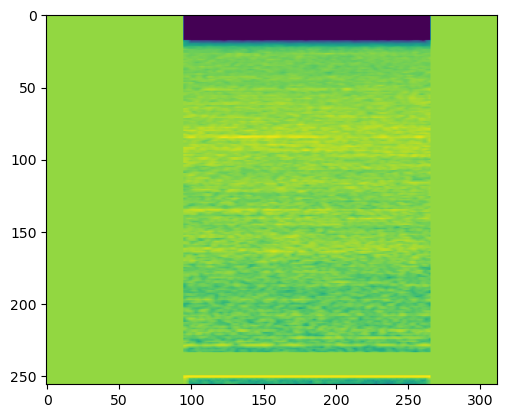

In [13]:
transform_mask_freq = T.FrequencyMasking(freq_mask_param=30)

show_image(transform_mask_freq(output))

## Model Training

### Approach 1: Creating a data block

/anaconda/envs/orca-v2-env/lib/python3.12/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1281) may be set too low.
  warnings.warn(


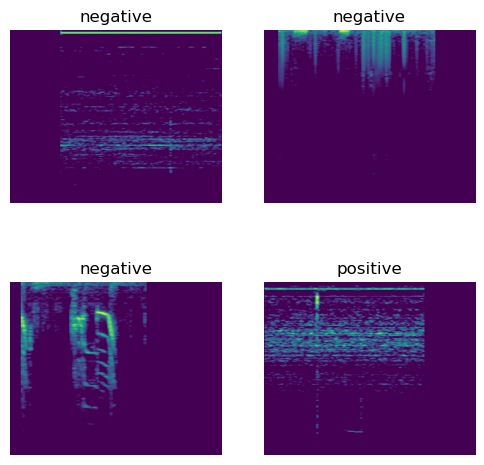

In [14]:
from fastai.data.block import DataBlock, CategoryBlock
from fastai.data.transforms import RandomSplitter
from fastai.vision.all import ImageBlock

def get_audio_files(path):
    return list(path.rglob("*.wav"))

def parent_label(path):
    return path.parent.name

transform_spec = T.MelSpectrogram(
    f_min=0.0,
    f_max=10000,
    hop_length=256,
    n_fft=2560,
    n_mels=256,
    pad=0,
    win_length=None,
)
transform_db = T.AmplitudeToDB(top_db=100)
pad_or_crop = PadOrCropTransform(4, hop=256)
mask_freq = T.FrequencyMasking(freq_mask_param=30)

# Define a function to load and transform the audio data
def load_audio(path):
    signal, sample_rate = torchaudio.load(path)
    spectrogram = transform_db(transform_spec(signal))
    spectrogram = pad_or_crop(spectrogram, sample_rate)
    # spectrogram = mask_freq(spectrogram)
    return spectrogram.squeeze(0)

# Create a DataBlock
audio_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_audio_files,
    splitter=RandomSplitter(valid_pct=.2, seed=4),
    get_x=load_audio,
    get_y=parent_label,
    # item_tfms=[F.to_tensor, mask_freq, F.to_pil_image],
)

# Create DataLoaders
data_folder = Path("./data/train/mldata/all/")
dls = audio_block.dataloaders(data_folder, bs=64)

# Show a batch of data
dls.show_batch(max_n=4)

In [15]:
from torchvision import models
from fastai.vision.all import accuracy, vision_learner

learn = vision_learner(dls, models.resnet18, metrics=accuracy)

# Using ImageNet pre-trained weights doesn't yield better performance
# learn = vision_learner(dls, models.resnet18, metrics=accuracy, weights="IMAGENET1K_V1")

/anaconda/envs/orca-v2-env/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location=device, **t

SuggestedLRs(valley=0.0012022644514217973)

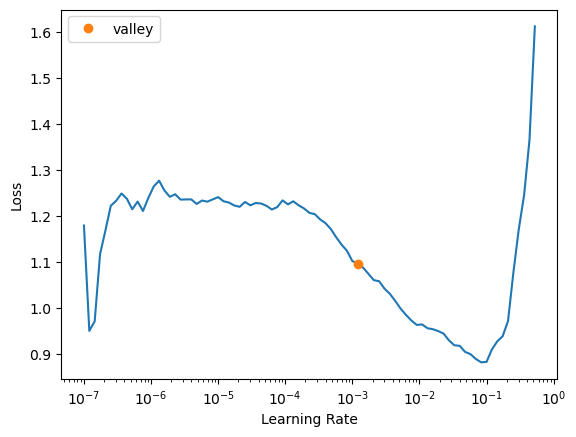

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(5, slice(2e-3, 2e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.445887,0.470377,0.840713,01:20
1,0.335060,0.190526,0.925486,01:20
2,0.243214,0.163156,0.939525,01:20
3,0.181447,0.149755,0.942765,01:19
4,0.144623,0.139288,0.944924,01:19


SuggestedLRs(valley=1.4454397387453355e-05)

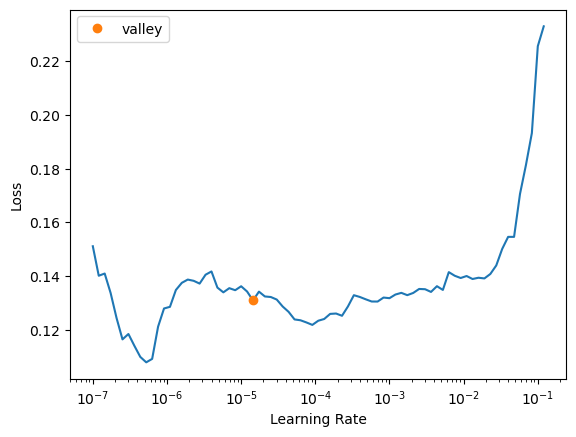

In [18]:
learn.lr_find()

In [19]:
learn.fit_one_cycle(5, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.139713,0.138515,0.946004,01:19
1,0.128125,0.141196,0.941685,01:19
2,0.127558,0.140591,0.941685,01:20
3,0.125190,0.140225,0.947624,01:19
4,0.125232,0.139877,0.948704,01:18


The above training achieves an accuracy of over 94% on the validation set.
This is slightly higher than the accuracy reported in `2_FastAI_StarterScript.ipynb`, which was ~93.7%.

### Approach 2: Creating data loaders from scratch

After working on this approach for a bit, I'm having a hard time getting 
it to work. Since we have a working version with the data block, I think
that's sufficient for now. 

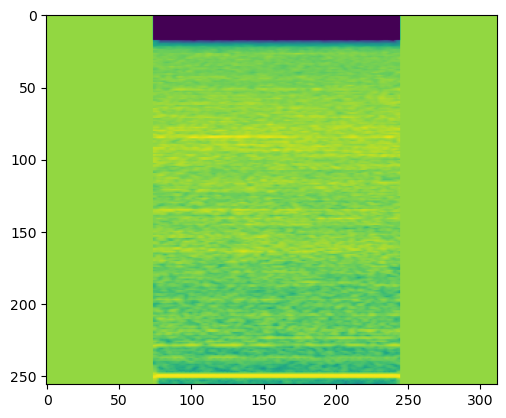

In [20]:
from torch.utils.data import Dataset
import torchaudio
import torchaudio.transforms as T

class AudioDataset(Dataset):
    def __init__(self, file_paths, target_duration):
        self.file_paths = list(file_paths)
        self.target_duration = target_duration
        self.transform_spec = T.MelSpectrogram(
            f_min=0.0,
            f_max=10000,
            hop_length=256,
            n_fft=2560,
            n_mels=256,
            pad=0,
            win_length=None,
        )
        self.transform_db = T.AmplitudeToDB(top_db=100)
        self.pad_or_crop = PadOrCropTransform(target_duration, hop=256)
        self.cache = {}

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        path = self.file_paths[idx]
        if path in self.cache:
            return self.cache[path]
        
        signal, sample_rate = torchaudio.load(path)
        spectrogram = self.transform_db(self.transform_spec(signal))
        spectrogram = self.pad_or_crop(spectrogram, sample_rate)
        self.cache[path] = spectrogram
        return spectrogram


dataset = AudioDataset(audio_files, target_duration=4)
show_image(dataset[0])

In [21]:
from fastai.data.core import DataLoader, DataLoaders
from fastai.vision.all import RandomSplitter

data_folder = Path("./data/train/mldata/all/")
data_files = list(data_folder.rglob("*.wav"))

train_files, valid_files = RandomSplitter(valid_pct=0.2, seed=42)(data_files)

train_ds = AudioDataset(train_files, target_duration=4)
valid_ds = AudioDataset(valid_files, target_duration=4)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64, shuffle=True)

dls = DataLoaders(train_dl, valid_dl)

In [22]:
# from torchvision import models
# from fastai.vision.all import accuracy, vision_learner

# learn = vision_learner(
#     dls, models.resnet18, metrics=accuracy, n_out=2, normalize=False
# )

## Model Evaluation

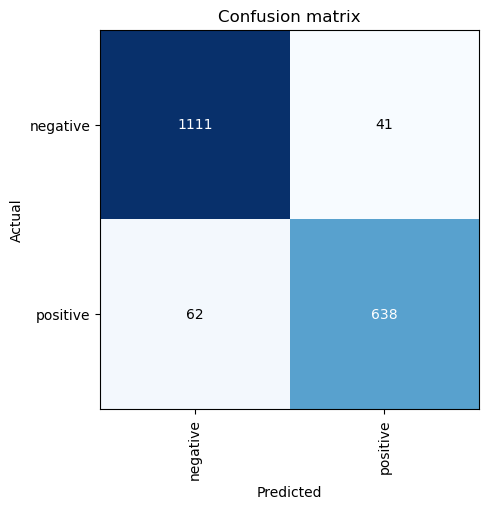

In [23]:
from fastai.vision.all import ClassificationInterpretation

interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(5,5))